In [1]:
from os import listdir
from os.path import isfile, join
import sys
import copy
import re
import numpy as np

from scipy.signal import stft
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import csv

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm
from utils import Person, simple_low_pass, exp_feat, window_spikes, analyze, do_tc_full
import pickle as pkl
import peakutils
import pywt

from jAER_utils.converter import aedat2numpy
from utils import analyze

import pandas as pd
import seaborn as sns
import cv2

In [17]:
# general stuff
fs = 200  # sampling frequency of MYO
VERBOSE = True
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/'
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']
classes_dict = {'pinky': 0, 'elle': 1, 'yo': 2, 'index': 3, 'thumb': 4}

Load all data into subject obects 

In [3]:
subjects = {}
names = [name for name in listdir(data_dir) if "emg" in name]
for name in names:
    _emg = np.load(data_dir + '{}'.format(name)).astype('float32')
    _ann = np.concatenate([np.array(['none']), np.load(data_dir + '{}'.format(name.replace("emg","ann")))[:-1]])
    
    subjects[name.split("_")[1]] = Person(name.split("_")[1], _emg, _ann, classes=classes)
    
    if VERBOSE:
        print("Loaded {}: EMG = [{}] // ANN = [{}]".format(name.split("_")[1], _emg.shape, len(_ann)))
print("Data Loaded! {} Sessions".format(len(subjects.keys())))

Loaded Charlotte1: EMG = [(25315, 8)] // ANN = [25315]
Loaded Simone3: EMG = [(25324, 8)] // ANN = [25324]
Loaded Enea3: EMG = [(25242, 8)] // ANN = [25242]
Loaded Marcus1: EMG = [(25294, 8)] // ANN = [25294]
Loaded Gemma1: EMG = [(24993, 8)] // ANN = [24993]
Loaded Bruno2: EMG = [(25331, 8)] // ANN = [25331]
Loaded Erika3: EMG = [(25332, 8)] // ANN = [25332]
Loaded Lyes3: EMG = [(25240, 8)] // ANN = [25240]
Loaded Baris3: EMG = [(25244, 8)] // ANN = [25244]
Loaded Simone2: EMG = [(25318, 8)] // ANN = [25318]
Loaded Bruno3: EMG = [(25318, 8)] // ANN = [25318]
Loaded Enea2: EMG = [(25328, 8)] // ANN = [25328]
Loaded Erika2: EMG = [(25330, 8)] // ANN = [25330]
Loaded Lyes2: EMG = [(25304, 8)] // ANN = [25304]
Loaded Baris2: EMG = [(25089, 8)] // ANN = [25089]
Loaded Melika1: EMG = [(25140, 8)] // ANN = [25140]
Loaded Gemma3: EMG = [(24903, 8)] // ANN = [24903]
Loaded Marcus3: EMG = [(25328, 8)] // ANN = [25328]
Loaded Enea1: EMG = [(25315, 8)] // ANN = [25315]
Loaded Simone1: EMG = [(253

In [4]:
# separates data in correct trial type
for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation)/1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials)
            data.begs[_class].append(b)
            data.ends[_class].append(e)
print("Done sorting trials!")

Done sorting trials!


Now every subject has different fields, each field is a dictionary and the keys are the gestures.
We have the following fields: begs (beginning time of trials), ends (end time of trials), trials (actual myo data)

In [5]:
# example, see that each gesture is 2 seconds
print(np.array(subjects['Gemma1'].begs['elle']) / fs)
print(np.array(subjects['Gemma1'].ends['elle']) / fs)

[  7.575  31.98   56.73   81.275 106.02 ]
[  9.515  33.95   58.73   83.265 108.02 ]


In [6]:
# this is to find the zero timestepping of the davis
def find_trigger(ts):
    return np.where(np.diff(ts) < 0)[0][0]

def create_frame(x, y, dim=(128, 128)):
    img = np.zeros(dim)
    for _x, _y in zip(x.astype('int32'), y.astype('int32')):
        img[dim[0] - 1 - _x,_y] += 1
    return np.log10(img / np.max(img) + 1e-10)

In [7]:
subject = 'Bruno2'
# decoders takes some time since it is a very long recordings, especially with DAVIS
events = aedat2numpy(data_dir + subject +'_dvs.aedat')
events = events[:, find_trigger(events[2]):]
events[2] = events[2] / 1e3
print(events.shape)

(4, 3359047)


(4, 20773)


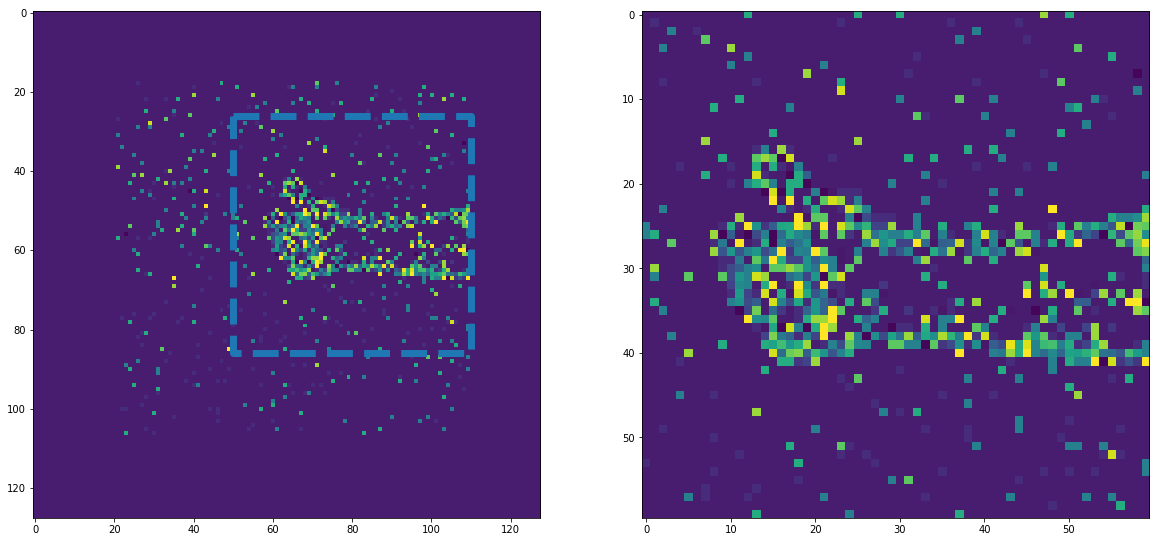

In [8]:
gesture = 'thumb'
trial = 3
# load beginning and end 
b = np.array(subjects[subject].begs[gesture][trial]) / fs
e = np.array(subjects[subject].ends[gesture][trial]) / fs

frame_size = 1.
shift = 1.
beginning = b + shift
ending = beginning + frame_size
# slice
sl = (events[2] > beginning) & (events[2] < ending)

img = events[:, sl]
print(img.shape)
fig, ax = plt.subplots(1, 2, figsize=(20,10))

beg_int = int(shift * fs)
end_int = int((shift + frame_size) * fs)

# dd = subjects[subject].trials[gesture][trial][beg_int:end_int]
# feat = analyze(dd, frame_len=0.01, frame_step=0.005, feat='RMS')
# for i in range(8):
#     _ = ax[1].plot(dd[:, i], label='channel{}'.format(i))
# ax[1].legend()

sll = (img[1] > 20) & (img[1] < 110) & (img[0] > 20) & (img[0] < 110)

frame = np.uint8(create_frame(img[1][sll], img[0][sll]) * 254)
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

M = cv2.moments(thresh)
x = int(M["m10"] / M["m00"])
y = int(M["m01"] / M["m00"])

_ = ax[0].imshow(frame)
ax[0].plot([x - 30, x + 30, x + 30, x - 30, x - 30], 
           [y  - 30, y  - 30, y + 30, y  + 30, y  - 30], '--', linewidth=7)

_ = ax[1].imshow(frame[y - 30: y + 30, x-30:x+30])



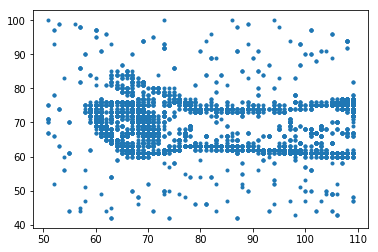

In [9]:
a = (img[0] > (x - 30)) & (img[0] < (x + 30))
b = (img[1] > (127 - y - 30)) & (img[1] < (127 - y + 30))
xx = img[0][a & b]
yy = img[1][a & b]
ts = img[2][a & b]
pol = img[3][a & b]

plt.plot(xx, yy, '.')

In [10]:
for subject, data in subjects.items():

    # decoders takes some time since it is a very long recordings, especially with DAVIS
    events = aedat2numpy(data_dir + subject +'_dvs.aedat')
    events = events[:, find_trigger(events[2]):]
    events[2] = events[2] / 1e3
    
    for gesture in classes:
        for trial in range(5):
            print("{} :: {} :: {}".format(subject, gesture, trial))
            # load beginning and end 
            b = np.array(data.begs[gesture][trial]) / fs
            e = np.array(data.ends[gesture][trial]) / fs

            frame_size = 2
            shift = 0.
            beginning = b + shift
            ending = beginning + frame_size

            # slice
            sl = (events[2] > beginning) & (events[2] < ending)

            img = events[:, sl]

            beg_int = int(shift * fs)
            end_int = int((shift + frame_size) * fs)

            sll = (img[1] > 20) & (img[1] < 110) & (img[0] > 20) & (img[0] < 110)

            frame = np.uint8(create_frame(img[1][sll], img[0][sll]) * 254)
            blurred = cv2.GaussianBlur(frame, (5, 5), 0)
            thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

            M = cv2.moments(thresh)
            x = int(M["m10"] / M["m00"])
            y = int(M["m01"] / M["m00"])

            a = (img[0] > (x - 30)) & (img[0] < (x + 30))
            b = (img[1] > (127 - y - 30)) & (img[1] < (127 - y + 30))
            xx = img[0][a & b]
            yy = img[1][a & b]
            ts = img[2][a & b]
            pol = img[3][a & b]

            data.x[gesture].append(xx - min(xx))
            data.y[gesture].append(yy - min(yy))
            data.ts[gesture].append(ts - min(ts))
            data.pol[gesture].append(pol)


Charlotte1 :: pinky :: 0
Charlotte1 :: pinky :: 1
Charlotte1 :: pinky :: 2
Charlotte1 :: pinky :: 3
Charlotte1 :: pinky :: 4
Charlotte1 :: elle :: 0
Charlotte1 :: elle :: 1
Charlotte1 :: elle :: 2
Charlotte1 :: elle :: 3
Charlotte1 :: elle :: 4
Charlotte1 :: yo :: 0
Charlotte1 :: yo :: 1
Charlotte1 :: yo :: 2
Charlotte1 :: yo :: 3
Charlotte1 :: yo :: 4
Charlotte1 :: index :: 0
Charlotte1 :: index :: 1
Charlotte1 :: index :: 2
Charlotte1 :: index :: 3
Charlotte1 :: index :: 4
Charlotte1 :: thumb :: 0
Charlotte1 :: thumb :: 1
Charlotte1 :: thumb :: 2
Charlotte1 :: thumb :: 3
Charlotte1 :: thumb :: 4
Simone3 :: pinky :: 0
Simone3 :: pinky :: 1
Simone3 :: pinky :: 2
Simone3 :: pinky :: 3
Simone3 :: pinky :: 4
Simone3 :: elle :: 0
Simone3 :: elle :: 1
Simone3 :: elle :: 2
Simone3 :: elle :: 3
Simone3 :: elle :: 4
Simone3 :: yo :: 0
Simone3 :: yo :: 1
Simone3 :: yo :: 2
Simone3 :: yo :: 3
Simone3 :: yo :: 4
Simone3 :: index :: 0
Simone3 :: index :: 1
Simone3 :: index :: 2
Simone3 :: index ::

Gemma3 :: pinky :: 2
Gemma3 :: pinky :: 3
Gemma3 :: pinky :: 4
Gemma3 :: elle :: 0
Gemma3 :: elle :: 1
Gemma3 :: elle :: 2
Gemma3 :: elle :: 3
Gemma3 :: elle :: 4
Gemma3 :: yo :: 0
Gemma3 :: yo :: 1
Gemma3 :: yo :: 2
Gemma3 :: yo :: 3
Gemma3 :: yo :: 4
Gemma3 :: index :: 0
Gemma3 :: index :: 1
Gemma3 :: index :: 2
Gemma3 :: index :: 3
Gemma3 :: index :: 4
Gemma3 :: thumb :: 0
Gemma3 :: thumb :: 1
Gemma3 :: thumb :: 2
Gemma3 :: thumb :: 3
Gemma3 :: thumb :: 4
Marcus3 :: pinky :: 0
Marcus3 :: pinky :: 1
Marcus3 :: pinky :: 2
Marcus3 :: pinky :: 3
Marcus3 :: pinky :: 4
Marcus3 :: elle :: 0
Marcus3 :: elle :: 1
Marcus3 :: elle :: 2
Marcus3 :: elle :: 3
Marcus3 :: elle :: 4
Marcus3 :: yo :: 0
Marcus3 :: yo :: 1
Marcus3 :: yo :: 2
Marcus3 :: yo :: 3
Marcus3 :: yo :: 4
Marcus3 :: index :: 0
Marcus3 :: index :: 1
Marcus3 :: index :: 2
Marcus3 :: index :: 3
Marcus3 :: index :: 4
Marcus3 :: thumb :: 0
Marcus3 :: thumb :: 1
Marcus3 :: thumb :: 2
Marcus3 :: thumb :: 3
Marcus3 :: thumb :: 4
Enea1 :

In [11]:
pkl.dump(subjects, open('10_people_dvs_emg.pkl', 'wb'))

In [13]:
data = pkl.load(open('10_people_dvs_emg.pkl', 'rb'))

# kps: 13, descriptors: (13, 128)
# kps: 11, descriptors: (11, 64)


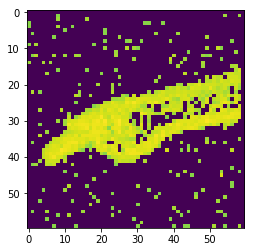

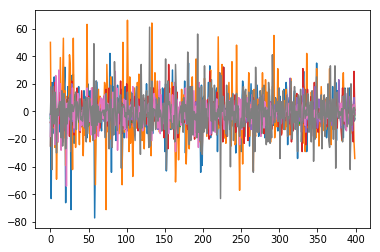

In [44]:
sub = 'Charlotte1'
trial = 1
gesture = 'index'
_x = data[sub].y[gesture][trial]
_y = data[sub].x[gesture][trial]
_ts = data[sub].ts[gesture][trial]
_p = data[sub].pol[gesture][trial]

fil = (_ts > 0.25) & (_ts < 1)
frame = create_frame(_x[fil], _y[fil], dim=(60, 60))
plt.imshow(frame)
plt.figure()
_ = plt.plot(data[sub].trials[gesture][trial])


frame = np.uint8(frame * 254)
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(thresh, None)

print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

surf = cv2.xfeatures2d.SURF_create()
(kps, descs) = surf.detectAndCompute(thresh, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

In [22]:
# extract sift and surf 
for subject, sub in data.items():
    for gesture in classes:
        for trial in range(5):

            _x = sub.y[gesture][trial]
            _y = sub.x[gesture][trial]
            _ts = sub.ts[gesture][trial]
            _p = sub.pol[gesture][trial]

            fil = (_ts > 0.200) & (_ts < 2)
            frame = create_frame(_x[fil], _y[fil], dim=(60, 60))

            frame = np.uint8(frame * 254)
            blurred = cv2.GaussianBlur(frame, (5, 5), 0)
            thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

            sift = cv2.xfeatures2d.SIFT_create()
            (kps, descs1) = sift.detectAndCompute(thresh, None)
            sub.sift[gesture].append(descs1)

            surf = cv2.xfeatures2d.SURF_create()
            (kps, descs2) = surf.detectAndCompute(thresh, None)
            sub.surf[gesture].append(descs2)
            
            print("{}::{}::{}::{}::{}".format(subject, gesture, trial, descs1.shape, descs2.shape))

Charlotte1::pinky::0::(24, 128)::(11, 64)
Charlotte1::pinky::1::(20, 128)::(18, 64)
Charlotte1::pinky::2::(11, 128)::(13, 64)
Charlotte1::pinky::3::(12, 128)::(16, 64)
Charlotte1::pinky::4::(12, 128)::(15, 64)
Charlotte1::elle::0::(16, 128)::(8, 64)
Charlotte1::elle::1::(23, 128)::(13, 64)
Charlotte1::elle::2::(23, 128)::(14, 64)
Charlotte1::elle::3::(14, 128)::(10, 64)
Charlotte1::elle::4::(16, 128)::(11, 64)
Charlotte1::yo::0::(13, 128)::(20, 64)
Charlotte1::yo::1::(21, 128)::(12, 64)
Charlotte1::yo::2::(19, 128)::(12, 64)
Charlotte1::yo::3::(12, 128)::(16, 64)
Charlotte1::yo::4::(15, 128)::(16, 64)
Charlotte1::index::0::(10, 128)::(15, 64)
Charlotte1::index::1::(14, 128)::(16, 64)
Charlotte1::index::2::(25, 128)::(14, 64)
Charlotte1::index::3::(9, 128)::(16, 64)
Charlotte1::index::4::(9, 128)::(16, 64)
Charlotte1::thumb::0::(15, 128)::(11, 64)
Charlotte1::thumb::1::(29, 128)::(11, 64)
Charlotte1::thumb::2::(31, 128)::(15, 64)
Charlotte1::thumb::3::(22, 128)::(15, 64)
Charlotte1::thu

Baris3::index::4::(10, 128)::(13, 64)
Baris3::thumb::0::(10, 128)::(11, 64)
Baris3::thumb::1::(26, 128)::(16, 64)
Baris3::thumb::2::(27, 128)::(15, 64)
Baris3::thumb::3::(20, 128)::(13, 64)
Baris3::thumb::4::(15, 128)::(13, 64)
Simone2::pinky::0::(19, 128)::(15, 64)
Simone2::pinky::1::(29, 128)::(14, 64)
Simone2::pinky::2::(22, 128)::(11, 64)
Simone2::pinky::3::(35, 128)::(8, 64)
Simone2::pinky::4::(22, 128)::(14, 64)
Simone2::elle::0::(36, 128)::(14, 64)
Simone2::elle::1::(26, 128)::(15, 64)
Simone2::elle::2::(20, 128)::(16, 64)
Simone2::elle::3::(29, 128)::(16, 64)
Simone2::elle::4::(14, 128)::(5, 64)
Simone2::yo::0::(38, 128)::(13, 64)
Simone2::yo::1::(25, 128)::(11, 64)
Simone2::yo::2::(24, 128)::(12, 64)
Simone2::yo::3::(53, 128)::(13, 64)
Simone2::yo::4::(26, 128)::(11, 64)
Simone2::index::0::(23, 128)::(20, 64)
Simone2::index::1::(36, 128)::(12, 64)
Simone2::index::2::(13, 128)::(10, 64)
Simone2::index::3::(36, 128)::(17, 64)
Simone2::index::4::(22, 128)::(11, 64)
Simone2::thumb

Marcus3::index::2::(22, 128)::(10, 64)
Marcus3::index::3::(16, 128)::(14, 64)
Marcus3::index::4::(10, 128)::(11, 64)
Marcus3::thumb::0::(17, 128)::(13, 64)
Marcus3::thumb::1::(33, 128)::(13, 64)
Marcus3::thumb::2::(36, 128)::(14, 64)
Marcus3::thumb::3::(19, 128)::(11, 64)
Marcus3::thumb::4::(19, 128)::(11, 64)
Enea1::pinky::0::(13, 128)::(10, 64)
Enea1::pinky::1::(23, 128)::(14, 64)
Enea1::pinky::2::(7, 128)::(13, 64)
Enea1::pinky::3::(17, 128)::(20, 64)
Enea1::pinky::4::(16, 128)::(8, 64)
Enea1::elle::0::(27, 128)::(13, 64)
Enea1::elle::1::(23, 128)::(8, 64)
Enea1::elle::2::(29, 128)::(15, 64)
Enea1::elle::3::(26, 128)::(16, 64)
Enea1::elle::4::(11, 128)::(16, 64)
Enea1::yo::0::(29, 128)::(14, 64)
Enea1::yo::1::(30, 128)::(8, 64)
Enea1::yo::2::(29, 128)::(10, 64)
Enea1::yo::3::(26, 128)::(22, 64)
Enea1::yo::4::(17, 128)::(9, 64)
Enea1::index::0::(7, 128)::(9, 64)
Enea1::index::1::(9, 128)::(12, 64)
Enea1::index::2::(9, 128)::(12, 64)
Enea1::index::3::(11, 128)::(14, 64)
Enea1::index::

Bruno1::yo::0::(17, 128)::(13, 64)
Bruno1::yo::1::(15, 128)::(14, 64)
Bruno1::yo::2::(18, 128)::(14, 64)
Bruno1::yo::3::(28, 128)::(11, 64)
Bruno1::yo::4::(24, 128)::(19, 64)
Bruno1::index::0::(13, 128)::(15, 64)
Bruno1::index::1::(17, 128)::(14, 64)
Bruno1::index::2::(7, 128)::(13, 64)
Bruno1::index::3::(31, 128)::(13, 64)
Bruno1::index::4::(29, 128)::(17, 64)
Bruno1::thumb::0::(21, 128)::(14, 64)
Bruno1::thumb::1::(12, 128)::(13, 64)
Bruno1::thumb::2::(24, 128)::(15, 64)
Bruno1::thumb::3::(26, 128)::(16, 64)
Bruno1::thumb::4::(18, 128)::(12, 64)
Gemma2::pinky::0::(19, 128)::(11, 64)
Gemma2::pinky::1::(25, 128)::(15, 64)
Gemma2::pinky::2::(25, 128)::(11, 64)
Gemma2::pinky::3::(16, 128)::(7, 64)
Gemma2::pinky::4::(16, 128)::(6, 64)
Gemma2::elle::0::(45, 128)::(8, 64)
Gemma2::elle::1::(30, 128)::(12, 64)
Gemma2::elle::2::(30, 128)::(7, 64)
Gemma2::elle::3::(21, 128)::(15, 64)
Gemma2::elle::4::(22, 128)::(12, 64)
Gemma2::yo::0::(26, 128)::(12, 64)
Gemma2::yo::1::(33, 128)::(16, 64)
Gemma

In [45]:
X1 = []
X2 = []
Y = []

for subject, sub in data.items():
    for gesture in classes:
        for trial in range(5):
            if sub.sift[gesture][trial].shape[0] >= 7 and sub.surf[gesture][trial].shape[0] >= 7: 
                X1.append(sub.sift[gesture][trial][:7])
                X2.append(sub.surf[gesture][trial][:7])
                Y.append(classes_dict[gesture])
            

X1 = np.array(X1)
X2 = np.array(X2)
X = np.hstack([X1.reshape(X1.shape[0], -1), X2.reshape(X1.shape[0], -1)])
Y = np.array(Y)

X -= np.mean(X, 0, keepdims=True)
X /= np.std(X, 0, keepdims=True) + 1e-15

print(np.array(X1).shape)
print(np.array(X2).shape)
print(np.array(Y).shape)


(690, 7, 128)
(690, 7, 64)
(690,)


In [49]:
print(do_tc_full(X, Y.reshape(-1,1 ), pca_comp=4, avg=True))

(0.9790660225442835, 0.2318840579710145, 0.004497339788653463, 0.0542269186488977)


In [65]:
# extract sift and surf 

X1 = []
X2 = []
Y = []

for subject, sub in data.items():
    for gesture in classes:
        for trial in range(5):

            _emg = sub.trials[gesture][trial]
            
            if _emg.shape[0] < 400:
                _emg = np.vstack([_emg, np.zeros((400 - _emg.shape[0], 8))])
            _emg = _emg[:400]
            print(_emg.shape)
            X2.append(_emg.reshape(10, -1, 8))
                                 
            _x = sub.y[gesture][trial]
            _y = sub.x[gesture][trial]
            _ts = sub.ts[gesture][trial]
            _p = sub.pol[gesture][trial]
            for i in [0., 0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4, 1.6, 1.8]:
                fil = (_ts > i) & (_ts < i + 0.2)
                frame = create_frame(_x[fil], _y[fil], dim=(60, 60))
                X1.append(frame)
                Y.append(classes_dict[gesture])
                print("{}::{}::{}::{}::{}".format(subject, gesture, trial, frame.shape, i))

(400, 8)
Charlotte1::pinky::0::(60, 60)::0.0
Charlotte1::pinky::0::(60, 60)::0.2
Charlotte1::pinky::0::(60, 60)::0.4
Charlotte1::pinky::0::(60, 60)::0.6
Charlotte1::pinky::0::(60, 60)::0.8
Charlotte1::pinky::0::(60, 60)::1.0
Charlotte1::pinky::0::(60, 60)::1.2
Charlotte1::pinky::0::(60, 60)::1.4
Charlotte1::pinky::0::(60, 60)::1.6
Charlotte1::pinky::0::(60, 60)::1.8
(400, 8)
Charlotte1::pinky::1::(60, 60)::0.0
Charlotte1::pinky::1::(60, 60)::0.2
Charlotte1::pinky::1::(60, 60)::0.4
Charlotte1::pinky::1::(60, 60)::0.6
Charlotte1::pinky::1::(60, 60)::0.8
Charlotte1::pinky::1::(60, 60)::1.0
Charlotte1::pinky::1::(60, 60)::1.2
Charlotte1::pinky::1::(60, 60)::1.4
Charlotte1::pinky::1::(60, 60)::1.6
Charlotte1::pinky::1::(60, 60)::1.8
(400, 8)
Charlotte1::pinky::2::(60, 60)::0.0
Charlotte1::pinky::2::(60, 60)::0.2
Charlotte1::pinky::2::(60, 60)::0.4
Charlotte1::pinky::2::(60, 60)::0.6
Charlotte1::pinky::2::(60, 60)::0.8
Charlotte1::pinky::2::(60, 60)::1.0
Charlotte1::pinky::2::(60, 60)::1.2
C

Charlotte1::thumb::4::(60, 60)::0.0
Charlotte1::thumb::4::(60, 60)::0.2
Charlotte1::thumb::4::(60, 60)::0.4
Charlotte1::thumb::4::(60, 60)::0.6
Charlotte1::thumb::4::(60, 60)::0.8
Charlotte1::thumb::4::(60, 60)::1.0
Charlotte1::thumb::4::(60, 60)::1.2
Charlotte1::thumb::4::(60, 60)::1.4
Charlotte1::thumb::4::(60, 60)::1.6
Charlotte1::thumb::4::(60, 60)::1.8
(400, 8)
Simone3::pinky::0::(60, 60)::0.0
Simone3::pinky::0::(60, 60)::0.2
Simone3::pinky::0::(60, 60)::0.4
Simone3::pinky::0::(60, 60)::0.6
Simone3::pinky::0::(60, 60)::0.8
Simone3::pinky::0::(60, 60)::1.0
Simone3::pinky::0::(60, 60)::1.2
Simone3::pinky::0::(60, 60)::1.4
Simone3::pinky::0::(60, 60)::1.6
Simone3::pinky::0::(60, 60)::1.8
(400, 8)
Simone3::pinky::1::(60, 60)::0.0
Simone3::pinky::1::(60, 60)::0.2
Simone3::pinky::1::(60, 60)::0.4
Simone3::pinky::1::(60, 60)::0.6
Simone3::pinky::1::(60, 60)::0.8
Simone3::pinky::1::(60, 60)::1.0
Simone3::pinky::1::(60, 60)::1.2
Simone3::pinky::1::(60, 60)::1.4
Simone3::pinky::1::(60, 60):

Enea3::pinky::0::(60, 60)::0.6
Enea3::pinky::0::(60, 60)::0.8
Enea3::pinky::0::(60, 60)::1.0
Enea3::pinky::0::(60, 60)::1.2
Enea3::pinky::0::(60, 60)::1.4
Enea3::pinky::0::(60, 60)::1.6
Enea3::pinky::0::(60, 60)::1.8
(400, 8)
Enea3::pinky::1::(60, 60)::0.0
Enea3::pinky::1::(60, 60)::0.2
Enea3::pinky::1::(60, 60)::0.4
Enea3::pinky::1::(60, 60)::0.6
Enea3::pinky::1::(60, 60)::0.8
Enea3::pinky::1::(60, 60)::1.0
Enea3::pinky::1::(60, 60)::1.2
Enea3::pinky::1::(60, 60)::1.4
Enea3::pinky::1::(60, 60)::1.6
Enea3::pinky::1::(60, 60)::1.8
(400, 8)
Enea3::pinky::2::(60, 60)::0.0
Enea3::pinky::2::(60, 60)::0.2
Enea3::pinky::2::(60, 60)::0.4
Enea3::pinky::2::(60, 60)::0.6
Enea3::pinky::2::(60, 60)::0.8
Enea3::pinky::2::(60, 60)::1.0
Enea3::pinky::2::(60, 60)::1.2
Enea3::pinky::2::(60, 60)::1.4
Enea3::pinky::2::(60, 60)::1.6
Enea3::pinky::2::(60, 60)::1.8
(400, 8)
Enea3::pinky::3::(60, 60)::0.0
Enea3::pinky::3::(60, 60)::0.2
Enea3::pinky::3::(60, 60)::0.4
Enea3::pinky::3::(60, 60)::0.6
Enea3::pinky

Marcus1::pinky::3::(60, 60)::1.8
(400, 8)
Marcus1::pinky::4::(60, 60)::0.0
Marcus1::pinky::4::(60, 60)::0.2
Marcus1::pinky::4::(60, 60)::0.4
Marcus1::pinky::4::(60, 60)::0.6
Marcus1::pinky::4::(60, 60)::0.8
Marcus1::pinky::4::(60, 60)::1.0
Marcus1::pinky::4::(60, 60)::1.2
Marcus1::pinky::4::(60, 60)::1.4
Marcus1::pinky::4::(60, 60)::1.6
Marcus1::pinky::4::(60, 60)::1.8
(400, 8)
Marcus1::elle::0::(60, 60)::0.0
Marcus1::elle::0::(60, 60)::0.2
Marcus1::elle::0::(60, 60)::0.4
Marcus1::elle::0::(60, 60)::0.6
Marcus1::elle::0::(60, 60)::0.8
Marcus1::elle::0::(60, 60)::1.0
Marcus1::elle::0::(60, 60)::1.2
Marcus1::elle::0::(60, 60)::1.4
Marcus1::elle::0::(60, 60)::1.6
Marcus1::elle::0::(60, 60)::1.8
(400, 8)
Marcus1::elle::1::(60, 60)::0.0
Marcus1::elle::1::(60, 60)::0.2
Marcus1::elle::1::(60, 60)::0.4
Marcus1::elle::1::(60, 60)::0.6
Marcus1::elle::1::(60, 60)::0.8
Marcus1::elle::1::(60, 60)::1.0
Marcus1::elle::1::(60, 60)::1.2
Marcus1::elle::1::(60, 60)::1.4
Marcus1::elle::1::(60, 60)::1.6
Ma

Gemma1::pinky::4::(60, 60)::0.8
Gemma1::pinky::4::(60, 60)::1.0
Gemma1::pinky::4::(60, 60)::1.2
Gemma1::pinky::4::(60, 60)::1.4
Gemma1::pinky::4::(60, 60)::1.6
Gemma1::pinky::4::(60, 60)::1.8
(400, 8)
Gemma1::elle::0::(60, 60)::0.0
Gemma1::elle::0::(60, 60)::0.2
Gemma1::elle::0::(60, 60)::0.4
Gemma1::elle::0::(60, 60)::0.6
Gemma1::elle::0::(60, 60)::0.8
Gemma1::elle::0::(60, 60)::1.0
Gemma1::elle::0::(60, 60)::1.2
Gemma1::elle::0::(60, 60)::1.4
Gemma1::elle::0::(60, 60)::1.6
Gemma1::elle::0::(60, 60)::1.8
(400, 8)
Gemma1::elle::1::(60, 60)::0.0
Gemma1::elle::1::(60, 60)::0.2
Gemma1::elle::1::(60, 60)::0.4
Gemma1::elle::1::(60, 60)::0.6
Gemma1::elle::1::(60, 60)::0.8
Gemma1::elle::1::(60, 60)::1.0
Gemma1::elle::1::(60, 60)::1.2
Gemma1::elle::1::(60, 60)::1.4
Gemma1::elle::1::(60, 60)::1.6
Gemma1::elle::1::(60, 60)::1.8
(400, 8)
Gemma1::elle::2::(60, 60)::0.0
Gemma1::elle::2::(60, 60)::0.2
Gemma1::elle::2::(60, 60)::0.4
Gemma1::elle::2::(60, 60)::0.6
Gemma1::elle::2::(60, 60)::0.8
Gemma1

Bruno2::elle::0::(60, 60)::0.0
Bruno2::elle::0::(60, 60)::0.2
Bruno2::elle::0::(60, 60)::0.4
Bruno2::elle::0::(60, 60)::0.6
Bruno2::elle::0::(60, 60)::0.8
Bruno2::elle::0::(60, 60)::1.0
Bruno2::elle::0::(60, 60)::1.2
Bruno2::elle::0::(60, 60)::1.4
Bruno2::elle::0::(60, 60)::1.6
Bruno2::elle::0::(60, 60)::1.8
(400, 8)
Bruno2::elle::1::(60, 60)::0.0
Bruno2::elle::1::(60, 60)::0.2
Bruno2::elle::1::(60, 60)::0.4
Bruno2::elle::1::(60, 60)::0.6
Bruno2::elle::1::(60, 60)::0.8
Bruno2::elle::1::(60, 60)::1.0
Bruno2::elle::1::(60, 60)::1.2
Bruno2::elle::1::(60, 60)::1.4
Bruno2::elle::1::(60, 60)::1.6
Bruno2::elle::1::(60, 60)::1.8
(400, 8)
Bruno2::elle::2::(60, 60)::0.0
Bruno2::elle::2::(60, 60)::0.2
Bruno2::elle::2::(60, 60)::0.4
Bruno2::elle::2::(60, 60)::0.6
Bruno2::elle::2::(60, 60)::0.8
Bruno2::elle::2::(60, 60)::1.0
Bruno2::elle::2::(60, 60)::1.2
Bruno2::elle::2::(60, 60)::1.4
Bruno2::elle::2::(60, 60)::1.6
Bruno2::elle::2::(60, 60)::1.8
(400, 8)
Bruno2::elle::3::(60, 60)::0.0
Bruno2::elle

Erika3::elle::1::(60, 60)::0.0
Erika3::elle::1::(60, 60)::0.2
Erika3::elle::1::(60, 60)::0.4
Erika3::elle::1::(60, 60)::0.6
Erika3::elle::1::(60, 60)::0.8
Erika3::elle::1::(60, 60)::1.0
Erika3::elle::1::(60, 60)::1.2
Erika3::elle::1::(60, 60)::1.4
Erika3::elle::1::(60, 60)::1.6
Erika3::elle::1::(60, 60)::1.8
(400, 8)
Erika3::elle::2::(60, 60)::0.0
Erika3::elle::2::(60, 60)::0.2
Erika3::elle::2::(60, 60)::0.4
Erika3::elle::2::(60, 60)::0.6
Erika3::elle::2::(60, 60)::0.8
Erika3::elle::2::(60, 60)::1.0
Erika3::elle::2::(60, 60)::1.2
Erika3::elle::2::(60, 60)::1.4
Erika3::elle::2::(60, 60)::1.6
Erika3::elle::2::(60, 60)::1.8
(400, 8)
Erika3::elle::3::(60, 60)::0.0
Erika3::elle::3::(60, 60)::0.2
Erika3::elle::3::(60, 60)::0.4
Erika3::elle::3::(60, 60)::0.6
Erika3::elle::3::(60, 60)::0.8
Erika3::elle::3::(60, 60)::1.0
Erika3::elle::3::(60, 60)::1.2
Erika3::elle::3::(60, 60)::1.4
Erika3::elle::3::(60, 60)::1.6
Erika3::elle::3::(60, 60)::1.8
(400, 8)
Erika3::elle::4::(60, 60)::0.0
Erika3::elle

Lyes3::elle::4::(60, 60)::0.6
Lyes3::elle::4::(60, 60)::0.8
Lyes3::elle::4::(60, 60)::1.0
Lyes3::elle::4::(60, 60)::1.2
Lyes3::elle::4::(60, 60)::1.4
Lyes3::elle::4::(60, 60)::1.6
Lyes3::elle::4::(60, 60)::1.8
(400, 8)
Lyes3::yo::0::(60, 60)::0.0
Lyes3::yo::0::(60, 60)::0.2
Lyes3::yo::0::(60, 60)::0.4
Lyes3::yo::0::(60, 60)::0.6
Lyes3::yo::0::(60, 60)::0.8
Lyes3::yo::0::(60, 60)::1.0
Lyes3::yo::0::(60, 60)::1.2
Lyes3::yo::0::(60, 60)::1.4
Lyes3::yo::0::(60, 60)::1.6
Lyes3::yo::0::(60, 60)::1.8
(400, 8)
Lyes3::yo::1::(60, 60)::0.0
Lyes3::yo::1::(60, 60)::0.2
Lyes3::yo::1::(60, 60)::0.4
Lyes3::yo::1::(60, 60)::0.6
Lyes3::yo::1::(60, 60)::0.8
Lyes3::yo::1::(60, 60)::1.0
Lyes3::yo::1::(60, 60)::1.2
Lyes3::yo::1::(60, 60)::1.4
Lyes3::yo::1::(60, 60)::1.6
Lyes3::yo::1::(60, 60)::1.8
(400, 8)
Lyes3::yo::2::(60, 60)::0.0
Lyes3::yo::2::(60, 60)::0.2
Lyes3::yo::2::(60, 60)::0.4
Lyes3::yo::2::(60, 60)::0.6
Lyes3::yo::2::(60, 60)::0.8
Lyes3::yo::2::(60, 60)::1.0
Lyes3::yo::2::(60, 60)::1.2
Lyes3::

Baris3::yo::0::(60, 60)::0.8
Baris3::yo::0::(60, 60)::1.0
Baris3::yo::0::(60, 60)::1.2
Baris3::yo::0::(60, 60)::1.4
Baris3::yo::0::(60, 60)::1.6
Baris3::yo::0::(60, 60)::1.8
(400, 8)
Baris3::yo::1::(60, 60)::0.0
Baris3::yo::1::(60, 60)::0.2
Baris3::yo::1::(60, 60)::0.4
Baris3::yo::1::(60, 60)::0.6
Baris3::yo::1::(60, 60)::0.8
Baris3::yo::1::(60, 60)::1.0
Baris3::yo::1::(60, 60)::1.2
Baris3::yo::1::(60, 60)::1.4
Baris3::yo::1::(60, 60)::1.6
Baris3::yo::1::(60, 60)::1.8
(400, 8)
Baris3::yo::2::(60, 60)::0.0
Baris3::yo::2::(60, 60)::0.2
Baris3::yo::2::(60, 60)::0.4
Baris3::yo::2::(60, 60)::0.6
Baris3::yo::2::(60, 60)::0.8
Baris3::yo::2::(60, 60)::1.0
Baris3::yo::2::(60, 60)::1.2
Baris3::yo::2::(60, 60)::1.4
Baris3::yo::2::(60, 60)::1.6
Baris3::yo::2::(60, 60)::1.8
(400, 8)
Baris3::yo::3::(60, 60)::0.0
Baris3::yo::3::(60, 60)::0.2
Baris3::yo::3::(60, 60)::0.4
Baris3::yo::3::(60, 60)::0.6
Baris3::yo::3::(60, 60)::0.8
Baris3::yo::3::(60, 60)::1.0
Baris3::yo::3::(60, 60)::1.2
Baris3::yo::3::(

Simone2::yo::2::(60, 60)::1.4
Simone2::yo::2::(60, 60)::1.6
Simone2::yo::2::(60, 60)::1.8
(400, 8)
Simone2::yo::3::(60, 60)::0.0
Simone2::yo::3::(60, 60)::0.2
Simone2::yo::3::(60, 60)::0.4
Simone2::yo::3::(60, 60)::0.6
Simone2::yo::3::(60, 60)::0.8
Simone2::yo::3::(60, 60)::1.0
Simone2::yo::3::(60, 60)::1.2
Simone2::yo::3::(60, 60)::1.4
Simone2::yo::3::(60, 60)::1.6
Simone2::yo::3::(60, 60)::1.8
(400, 8)
Simone2::yo::4::(60, 60)::0.0
Simone2::yo::4::(60, 60)::0.2
Simone2::yo::4::(60, 60)::0.4
Simone2::yo::4::(60, 60)::0.6
Simone2::yo::4::(60, 60)::0.8
Simone2::yo::4::(60, 60)::1.0
Simone2::yo::4::(60, 60)::1.2
Simone2::yo::4::(60, 60)::1.4
Simone2::yo::4::(60, 60)::1.6
Simone2::yo::4::(60, 60)::1.8
(400, 8)
Simone2::index::0::(60, 60)::0.0
Simone2::index::0::(60, 60)::0.2
Simone2::index::0::(60, 60)::0.4
Simone2::index::0::(60, 60)::0.6
Simone2::index::0::(60, 60)::0.8
Simone2::index::0::(60, 60)::1.0
Simone2::index::0::(60, 60)::1.2
Simone2::index::0::(60, 60)::1.4
Simone2::index::0::

Bruno3::yo::2::(60, 60)::1.8
(400, 8)
Bruno3::yo::3::(60, 60)::0.0
Bruno3::yo::3::(60, 60)::0.2
Bruno3::yo::3::(60, 60)::0.4
Bruno3::yo::3::(60, 60)::0.6
Bruno3::yo::3::(60, 60)::0.8
Bruno3::yo::3::(60, 60)::1.0
Bruno3::yo::3::(60, 60)::1.2
Bruno3::yo::3::(60, 60)::1.4
Bruno3::yo::3::(60, 60)::1.6
Bruno3::yo::3::(60, 60)::1.8
(400, 8)
Bruno3::yo::4::(60, 60)::0.0
Bruno3::yo::4::(60, 60)::0.2
Bruno3::yo::4::(60, 60)::0.4
Bruno3::yo::4::(60, 60)::0.6
Bruno3::yo::4::(60, 60)::0.8
Bruno3::yo::4::(60, 60)::1.0
Bruno3::yo::4::(60, 60)::1.2
Bruno3::yo::4::(60, 60)::1.4
Bruno3::yo::4::(60, 60)::1.6
Bruno3::yo::4::(60, 60)::1.8
(400, 8)
Bruno3::index::0::(60, 60)::0.0
Bruno3::index::0::(60, 60)::0.2
Bruno3::index::0::(60, 60)::0.4
Bruno3::index::0::(60, 60)::0.6
Bruno3::index::0::(60, 60)::0.8
Bruno3::index::0::(60, 60)::1.0
Bruno3::index::0::(60, 60)::1.2
Bruno3::index::0::(60, 60)::1.4
Bruno3::index::0::(60, 60)::1.6
Bruno3::index::0::(60, 60)::1.8
(400, 8)
Bruno3::index::1::(60, 60)::0.0
Bru

Enea2::yo::4::(60, 60)::0.6
Enea2::yo::4::(60, 60)::0.8
Enea2::yo::4::(60, 60)::1.0
Enea2::yo::4::(60, 60)::1.2
Enea2::yo::4::(60, 60)::1.4
Enea2::yo::4::(60, 60)::1.6
Enea2::yo::4::(60, 60)::1.8
(400, 8)
Enea2::index::0::(60, 60)::0.0
Enea2::index::0::(60, 60)::0.2
Enea2::index::0::(60, 60)::0.4
Enea2::index::0::(60, 60)::0.6
Enea2::index::0::(60, 60)::0.8
Enea2::index::0::(60, 60)::1.0
Enea2::index::0::(60, 60)::1.2
Enea2::index::0::(60, 60)::1.4
Enea2::index::0::(60, 60)::1.6
Enea2::index::0::(60, 60)::1.8
(400, 8)
Enea2::index::1::(60, 60)::0.0
Enea2::index::1::(60, 60)::0.2
Enea2::index::1::(60, 60)::0.4
Enea2::index::1::(60, 60)::0.6
Enea2::index::1::(60, 60)::0.8
Enea2::index::1::(60, 60)::1.0
Enea2::index::1::(60, 60)::1.2
Enea2::index::1::(60, 60)::1.4
Enea2::index::1::(60, 60)::1.6
Enea2::index::1::(60, 60)::1.8
(400, 8)
Enea2::index::2::(60, 60)::0.0
Enea2::index::2::(60, 60)::0.2
Enea2::index::2::(60, 60)::0.4
Enea2::index::2::(60, 60)::0.6
Enea2::index::2::(60, 60)::0.8
En

Erika2::index::2::(60, 60)::0.0
Erika2::index::2::(60, 60)::0.2
Erika2::index::2::(60, 60)::0.4
Erika2::index::2::(60, 60)::0.6
Erika2::index::2::(60, 60)::0.8
Erika2::index::2::(60, 60)::1.0
Erika2::index::2::(60, 60)::1.2
Erika2::index::2::(60, 60)::1.4
Erika2::index::2::(60, 60)::1.6
Erika2::index::2::(60, 60)::1.8
(400, 8)
Erika2::index::3::(60, 60)::0.0
Erika2::index::3::(60, 60)::0.2
Erika2::index::3::(60, 60)::0.4
Erika2::index::3::(60, 60)::0.6
Erika2::index::3::(60, 60)::0.8
Erika2::index::3::(60, 60)::1.0
Erika2::index::3::(60, 60)::1.2
Erika2::index::3::(60, 60)::1.4
Erika2::index::3::(60, 60)::1.6
Erika2::index::3::(60, 60)::1.8
(400, 8)
Erika2::index::4::(60, 60)::0.0
Erika2::index::4::(60, 60)::0.2
Erika2::index::4::(60, 60)::0.4
Erika2::index::4::(60, 60)::0.6
Erika2::index::4::(60, 60)::0.8
Erika2::index::4::(60, 60)::1.0
Erika2::index::4::(60, 60)::1.2
Erika2::index::4::(60, 60)::1.4
Erika2::index::4::(60, 60)::1.6
Erika2::index::4::(60, 60)::1.8
(400, 8)
Erika2::thumb

Lyes2::thumb::0::(60, 60)::0.6
Lyes2::thumb::0::(60, 60)::0.8
Lyes2::thumb::0::(60, 60)::1.0
Lyes2::thumb::0::(60, 60)::1.2
Lyes2::thumb::0::(60, 60)::1.4
Lyes2::thumb::0::(60, 60)::1.6
Lyes2::thumb::0::(60, 60)::1.8
(400, 8)
Lyes2::thumb::1::(60, 60)::0.0
Lyes2::thumb::1::(60, 60)::0.2
Lyes2::thumb::1::(60, 60)::0.4
Lyes2::thumb::1::(60, 60)::0.6
Lyes2::thumb::1::(60, 60)::0.8
Lyes2::thumb::1::(60, 60)::1.0
Lyes2::thumb::1::(60, 60)::1.2
Lyes2::thumb::1::(60, 60)::1.4
Lyes2::thumb::1::(60, 60)::1.6
Lyes2::thumb::1::(60, 60)::1.8
(400, 8)
Lyes2::thumb::2::(60, 60)::0.0
Lyes2::thumb::2::(60, 60)::0.2
Lyes2::thumb::2::(60, 60)::0.4
Lyes2::thumb::2::(60, 60)::0.6
Lyes2::thumb::2::(60, 60)::0.8
Lyes2::thumb::2::(60, 60)::1.0
Lyes2::thumb::2::(60, 60)::1.2
Lyes2::thumb::2::(60, 60)::1.4
Lyes2::thumb::2::(60, 60)::1.6
Lyes2::thumb::2::(60, 60)::1.8
(400, 8)
Lyes2::thumb::3::(60, 60)::0.0
Lyes2::thumb::3::(60, 60)::0.2
Lyes2::thumb::3::(60, 60)::0.4
Lyes2::thumb::3::(60, 60)::0.6
Lyes2::thumb

Melika1::pinky::0::(60, 60)::0.2
Melika1::pinky::0::(60, 60)::0.4
Melika1::pinky::0::(60, 60)::0.6
Melika1::pinky::0::(60, 60)::0.8
Melika1::pinky::0::(60, 60)::1.0
Melika1::pinky::0::(60, 60)::1.2
Melika1::pinky::0::(60, 60)::1.4
Melika1::pinky::0::(60, 60)::1.6
Melika1::pinky::0::(60, 60)::1.8
(400, 8)
Melika1::pinky::1::(60, 60)::0.0
Melika1::pinky::1::(60, 60)::0.2
Melika1::pinky::1::(60, 60)::0.4
Melika1::pinky::1::(60, 60)::0.6
Melika1::pinky::1::(60, 60)::0.8
Melika1::pinky::1::(60, 60)::1.0
Melika1::pinky::1::(60, 60)::1.2
Melika1::pinky::1::(60, 60)::1.4
Melika1::pinky::1::(60, 60)::1.6
Melika1::pinky::1::(60, 60)::1.8
(400, 8)
Melika1::pinky::2::(60, 60)::0.0
Melika1::pinky::2::(60, 60)::0.2
Melika1::pinky::2::(60, 60)::0.4
Melika1::pinky::2::(60, 60)::0.6
Melika1::pinky::2::(60, 60)::0.8
Melika1::pinky::2::(60, 60)::1.0
Melika1::pinky::2::(60, 60)::1.2
Melika1::pinky::2::(60, 60)::1.4
Melika1::pinky::2::(60, 60)::1.6
Melika1::pinky::2::(60, 60)::1.8
(400, 8)
Melika1::pinky::

Gemma3::pinky::1::(60, 60)::1.2
Gemma3::pinky::1::(60, 60)::1.4
Gemma3::pinky::1::(60, 60)::1.6
Gemma3::pinky::1::(60, 60)::1.8
(400, 8)
Gemma3::pinky::2::(60, 60)::0.0
Gemma3::pinky::2::(60, 60)::0.2
Gemma3::pinky::2::(60, 60)::0.4
Gemma3::pinky::2::(60, 60)::0.6
Gemma3::pinky::2::(60, 60)::0.8
Gemma3::pinky::2::(60, 60)::1.0
Gemma3::pinky::2::(60, 60)::1.2
Gemma3::pinky::2::(60, 60)::1.4
Gemma3::pinky::2::(60, 60)::1.6
Gemma3::pinky::2::(60, 60)::1.8
(400, 8)
Gemma3::pinky::3::(60, 60)::0.0
Gemma3::pinky::3::(60, 60)::0.2
Gemma3::pinky::3::(60, 60)::0.4
Gemma3::pinky::3::(60, 60)::0.6
Gemma3::pinky::3::(60, 60)::0.8
Gemma3::pinky::3::(60, 60)::1.0
Gemma3::pinky::3::(60, 60)::1.2
Gemma3::pinky::3::(60, 60)::1.4
Gemma3::pinky::3::(60, 60)::1.6
Gemma3::pinky::3::(60, 60)::1.8
(400, 8)
Gemma3::pinky::4::(60, 60)::0.0
Gemma3::pinky::4::(60, 60)::0.2
Gemma3::pinky::4::(60, 60)::0.4
Gemma3::pinky::4::(60, 60)::0.6
Gemma3::pinky::4::(60, 60)::0.8
Gemma3::pinky::4::(60, 60)::1.0
Gemma3::pinky

Marcus3::elle::0::(60, 60)::0.4
Marcus3::elle::0::(60, 60)::0.6
Marcus3::elle::0::(60, 60)::0.8
Marcus3::elle::0::(60, 60)::1.0
Marcus3::elle::0::(60, 60)::1.2
Marcus3::elle::0::(60, 60)::1.4
Marcus3::elle::0::(60, 60)::1.6
Marcus3::elle::0::(60, 60)::1.8
(400, 8)
Marcus3::elle::1::(60, 60)::0.0
Marcus3::elle::1::(60, 60)::0.2
Marcus3::elle::1::(60, 60)::0.4
Marcus3::elle::1::(60, 60)::0.6
Marcus3::elle::1::(60, 60)::0.8
Marcus3::elle::1::(60, 60)::1.0
Marcus3::elle::1::(60, 60)::1.2
Marcus3::elle::1::(60, 60)::1.4
Marcus3::elle::1::(60, 60)::1.6
Marcus3::elle::1::(60, 60)::1.8
(400, 8)
Marcus3::elle::2::(60, 60)::0.0
Marcus3::elle::2::(60, 60)::0.2
Marcus3::elle::2::(60, 60)::0.4
Marcus3::elle::2::(60, 60)::0.6
Marcus3::elle::2::(60, 60)::0.8
Marcus3::elle::2::(60, 60)::1.0
Marcus3::elle::2::(60, 60)::1.2
Marcus3::elle::2::(60, 60)::1.4
Marcus3::elle::2::(60, 60)::1.6
Marcus3::elle::2::(60, 60)::1.8
(400, 8)
Marcus3::elle::3::(60, 60)::0.0
Marcus3::elle::3::(60, 60)::0.2
Marcus3::elle

Enea1::elle::1::(60, 60)::0.2
Enea1::elle::1::(60, 60)::0.4
Enea1::elle::1::(60, 60)::0.6
Enea1::elle::1::(60, 60)::0.8
Enea1::elle::1::(60, 60)::1.0
Enea1::elle::1::(60, 60)::1.2
Enea1::elle::1::(60, 60)::1.4
Enea1::elle::1::(60, 60)::1.6
Enea1::elle::1::(60, 60)::1.8
(400, 8)
Enea1::elle::2::(60, 60)::0.0
Enea1::elle::2::(60, 60)::0.2
Enea1::elle::2::(60, 60)::0.4
Enea1::elle::2::(60, 60)::0.6
Enea1::elle::2::(60, 60)::0.8
Enea1::elle::2::(60, 60)::1.0
Enea1::elle::2::(60, 60)::1.2
Enea1::elle::2::(60, 60)::1.4
Enea1::elle::2::(60, 60)::1.6
Enea1::elle::2::(60, 60)::1.8
(400, 8)
Enea1::elle::3::(60, 60)::0.0
Enea1::elle::3::(60, 60)::0.2
Enea1::elle::3::(60, 60)::0.4
Enea1::elle::3::(60, 60)::0.6
Enea1::elle::3::(60, 60)::0.8
Enea1::elle::3::(60, 60)::1.0
Enea1::elle::3::(60, 60)::1.2
Enea1::elle::3::(60, 60)::1.4
Enea1::elle::3::(60, 60)::1.6
Enea1::elle::3::(60, 60)::1.8
(400, 8)
Enea1::elle::4::(60, 60)::0.0
Enea1::elle::4::(60, 60)::0.2
Enea1::elle::4::(60, 60)::0.4
Enea1::elle::

Simone1::elle::2::(60, 60)::0.4
Simone1::elle::2::(60, 60)::0.6
Simone1::elle::2::(60, 60)::0.8
Simone1::elle::2::(60, 60)::1.0
Simone1::elle::2::(60, 60)::1.2
Simone1::elle::2::(60, 60)::1.4
Simone1::elle::2::(60, 60)::1.6
Simone1::elle::2::(60, 60)::1.8
(400, 8)
Simone1::elle::3::(60, 60)::0.0
Simone1::elle::3::(60, 60)::0.2
Simone1::elle::3::(60, 60)::0.4
Simone1::elle::3::(60, 60)::0.6
Simone1::elle::3::(60, 60)::0.8
Simone1::elle::3::(60, 60)::1.0
Simone1::elle::3::(60, 60)::1.2
Simone1::elle::3::(60, 60)::1.4
Simone1::elle::3::(60, 60)::1.6
Simone1::elle::3::(60, 60)::1.8
(400, 8)
Simone1::elle::4::(60, 60)::0.0
Simone1::elle::4::(60, 60)::0.2
Simone1::elle::4::(60, 60)::0.4
Simone1::elle::4::(60, 60)::0.6
Simone1::elle::4::(60, 60)::0.8
Simone1::elle::4::(60, 60)::1.0
Simone1::elle::4::(60, 60)::1.2
Simone1::elle::4::(60, 60)::1.4
Simone1::elle::4::(60, 60)::1.6
Simone1::elle::4::(60, 60)::1.8
(400, 8)
Simone1::yo::0::(60, 60)::0.0
Simone1::yo::0::(60, 60)::0.2
Simone1::yo::0::(

Charlotte3::elle::4::(60, 60)::0.4
Charlotte3::elle::4::(60, 60)::0.6
Charlotte3::elle::4::(60, 60)::0.8
Charlotte3::elle::4::(60, 60)::1.0
Charlotte3::elle::4::(60, 60)::1.2
Charlotte3::elle::4::(60, 60)::1.4
Charlotte3::elle::4::(60, 60)::1.6
Charlotte3::elle::4::(60, 60)::1.8
(400, 8)
Charlotte3::yo::0::(60, 60)::0.0
Charlotte3::yo::0::(60, 60)::0.2
Charlotte3::yo::0::(60, 60)::0.4
Charlotte3::yo::0::(60, 60)::0.6
Charlotte3::yo::0::(60, 60)::0.8
Charlotte3::yo::0::(60, 60)::1.0
Charlotte3::yo::0::(60, 60)::1.2
Charlotte3::yo::0::(60, 60)::1.4
Charlotte3::yo::0::(60, 60)::1.6
Charlotte3::yo::0::(60, 60)::1.8
(400, 8)
Charlotte3::yo::1::(60, 60)::0.0
Charlotte3::yo::1::(60, 60)::0.2
Charlotte3::yo::1::(60, 60)::0.4
Charlotte3::yo::1::(60, 60)::0.6
Charlotte3::yo::1::(60, 60)::0.8
Charlotte3::yo::1::(60, 60)::1.0
Charlotte3::yo::1::(60, 60)::1.2
Charlotte3::yo::1::(60, 60)::1.4
Charlotte3::yo::1::(60, 60)::1.6
Charlotte3::yo::1::(60, 60)::1.8
(400, 8)
Charlotte3::yo::2::(60, 60)::0.0


Baris1::yo::1::(60, 60)::0.2
Baris1::yo::1::(60, 60)::0.4
Baris1::yo::1::(60, 60)::0.6
Baris1::yo::1::(60, 60)::0.8
Baris1::yo::1::(60, 60)::1.0
Baris1::yo::1::(60, 60)::1.2
Baris1::yo::1::(60, 60)::1.4
Baris1::yo::1::(60, 60)::1.6
Baris1::yo::1::(60, 60)::1.8
(400, 8)
Baris1::yo::2::(60, 60)::0.0
Baris1::yo::2::(60, 60)::0.2
Baris1::yo::2::(60, 60)::0.4
Baris1::yo::2::(60, 60)::0.6
Baris1::yo::2::(60, 60)::0.8
Baris1::yo::2::(60, 60)::1.0
Baris1::yo::2::(60, 60)::1.2
Baris1::yo::2::(60, 60)::1.4
Baris1::yo::2::(60, 60)::1.6
Baris1::yo::2::(60, 60)::1.8
(400, 8)
Baris1::yo::3::(60, 60)::0.0
Baris1::yo::3::(60, 60)::0.2
Baris1::yo::3::(60, 60)::0.4
Baris1::yo::3::(60, 60)::0.6
Baris1::yo::3::(60, 60)::0.8
Baris1::yo::3::(60, 60)::1.0
Baris1::yo::3::(60, 60)::1.2
Baris1::yo::3::(60, 60)::1.4
Baris1::yo::3::(60, 60)::1.6
Baris1::yo::3::(60, 60)::1.8
(400, 8)
Baris1::yo::4::(60, 60)::0.0
Baris1::yo::4::(60, 60)::0.2
Baris1::yo::4::(60, 60)::0.4
Baris1::yo::4::(60, 60)::0.6
Baris1::yo::4::(

Melika2::yo::2::(60, 60)::1.6
Melika2::yo::2::(60, 60)::1.8
(400, 8)
Melika2::yo::3::(60, 60)::0.0
Melika2::yo::3::(60, 60)::0.2
Melika2::yo::3::(60, 60)::0.4
Melika2::yo::3::(60, 60)::0.6
Melika2::yo::3::(60, 60)::0.8
Melika2::yo::3::(60, 60)::1.0
Melika2::yo::3::(60, 60)::1.2
Melika2::yo::3::(60, 60)::1.4
Melika2::yo::3::(60, 60)::1.6
Melika2::yo::3::(60, 60)::1.8
(400, 8)
Melika2::yo::4::(60, 60)::0.0
Melika2::yo::4::(60, 60)::0.2
Melika2::yo::4::(60, 60)::0.4
Melika2::yo::4::(60, 60)::0.6
Melika2::yo::4::(60, 60)::0.8
Melika2::yo::4::(60, 60)::1.0
Melika2::yo::4::(60, 60)::1.2
Melika2::yo::4::(60, 60)::1.4
Melika2::yo::4::(60, 60)::1.6
Melika2::yo::4::(60, 60)::1.8
(400, 8)
Melika2::index::0::(60, 60)::0.0
Melika2::index::0::(60, 60)::0.2
Melika2::index::0::(60, 60)::0.4
Melika2::index::0::(60, 60)::0.6
Melika2::index::0::(60, 60)::0.8
Melika2::index::0::(60, 60)::1.0
Melika2::index::0::(60, 60)::1.2
Melika2::index::0::(60, 60)::1.4
Melika2::index::0::(60, 60)::1.6
Melika2::index::

Lyes1::index::0::(60, 60)::1.6
Lyes1::index::0::(60, 60)::1.8
(400, 8)
Lyes1::index::1::(60, 60)::0.0
Lyes1::index::1::(60, 60)::0.2
Lyes1::index::1::(60, 60)::0.4
Lyes1::index::1::(60, 60)::0.6
Lyes1::index::1::(60, 60)::0.8
Lyes1::index::1::(60, 60)::1.0
Lyes1::index::1::(60, 60)::1.2
Lyes1::index::1::(60, 60)::1.4
Lyes1::index::1::(60, 60)::1.6
Lyes1::index::1::(60, 60)::1.8
(400, 8)
Lyes1::index::2::(60, 60)::0.0
Lyes1::index::2::(60, 60)::0.2
Lyes1::index::2::(60, 60)::0.4
Lyes1::index::2::(60, 60)::0.6
Lyes1::index::2::(60, 60)::0.8
Lyes1::index::2::(60, 60)::1.0
Lyes1::index::2::(60, 60)::1.2
Lyes1::index::2::(60, 60)::1.4
Lyes1::index::2::(60, 60)::1.6
Lyes1::index::2::(60, 60)::1.8
(400, 8)
Lyes1::index::3::(60, 60)::0.0
Lyes1::index::3::(60, 60)::0.2
Lyes1::index::3::(60, 60)::0.4
Lyes1::index::3::(60, 60)::0.6
Lyes1::index::3::(60, 60)::0.8
Lyes1::index::3::(60, 60)::1.0
Lyes1::index::3::(60, 60)::1.2
Lyes1::index::3::(60, 60)::1.4
Lyes1::index::3::(60, 60)::1.6
Lyes1::index

Erika1::index::3::(60, 60)::0.6
Erika1::index::3::(60, 60)::0.8
Erika1::index::3::(60, 60)::1.0
Erika1::index::3::(60, 60)::1.2
Erika1::index::3::(60, 60)::1.4
Erika1::index::3::(60, 60)::1.6
Erika1::index::3::(60, 60)::1.8
(400, 8)
Erika1::index::4::(60, 60)::0.0
Erika1::index::4::(60, 60)::0.2
Erika1::index::4::(60, 60)::0.4
Erika1::index::4::(60, 60)::0.6
Erika1::index::4::(60, 60)::0.8
Erika1::index::4::(60, 60)::1.0
Erika1::index::4::(60, 60)::1.2
Erika1::index::4::(60, 60)::1.4
Erika1::index::4::(60, 60)::1.6
Erika1::index::4::(60, 60)::1.8
(400, 8)
Erika1::thumb::0::(60, 60)::0.0
Erika1::thumb::0::(60, 60)::0.2
Erika1::thumb::0::(60, 60)::0.4
Erika1::thumb::0::(60, 60)::0.6
Erika1::thumb::0::(60, 60)::0.8
Erika1::thumb::0::(60, 60)::1.0
Erika1::thumb::0::(60, 60)::1.2
Erika1::thumb::0::(60, 60)::1.4
Erika1::thumb::0::(60, 60)::1.6
Erika1::thumb::0::(60, 60)::1.8
(400, 8)
Erika1::thumb::1::(60, 60)::0.0
Erika1::thumb::1::(60, 60)::0.2
Erika1::thumb::1::(60, 60)::0.4
Erika1::thumb

Marcus2::thumb::0::(60, 60)::0.2
Marcus2::thumb::0::(60, 60)::0.4
Marcus2::thumb::0::(60, 60)::0.6
Marcus2::thumb::0::(60, 60)::0.8
Marcus2::thumb::0::(60, 60)::1.0
Marcus2::thumb::0::(60, 60)::1.2
Marcus2::thumb::0::(60, 60)::1.4
Marcus2::thumb::0::(60, 60)::1.6
Marcus2::thumb::0::(60, 60)::1.8
(400, 8)
Marcus2::thumb::1::(60, 60)::0.0
Marcus2::thumb::1::(60, 60)::0.2
Marcus2::thumb::1::(60, 60)::0.4
Marcus2::thumb::1::(60, 60)::0.6
Marcus2::thumb::1::(60, 60)::0.8
Marcus2::thumb::1::(60, 60)::1.0
Marcus2::thumb::1::(60, 60)::1.2
Marcus2::thumb::1::(60, 60)::1.4
Marcus2::thumb::1::(60, 60)::1.6
Marcus2::thumb::1::(60, 60)::1.8
(400, 8)
Marcus2::thumb::2::(60, 60)::0.0
Marcus2::thumb::2::(60, 60)::0.2
Marcus2::thumb::2::(60, 60)::0.4
Marcus2::thumb::2::(60, 60)::0.6
Marcus2::thumb::2::(60, 60)::0.8
Marcus2::thumb::2::(60, 60)::1.0
Marcus2::thumb::2::(60, 60)::1.2
Marcus2::thumb::2::(60, 60)::1.4
Marcus2::thumb::2::(60, 60)::1.6
Marcus2::thumb::2::(60, 60)::1.8
(400, 8)
Marcus2::thumb::

Bruno1::thumb::1::(60, 60)::1.4
Bruno1::thumb::1::(60, 60)::1.6
Bruno1::thumb::1::(60, 60)::1.8
(400, 8)
Bruno1::thumb::2::(60, 60)::0.0
Bruno1::thumb::2::(60, 60)::0.2
Bruno1::thumb::2::(60, 60)::0.4
Bruno1::thumb::2::(60, 60)::0.6
Bruno1::thumb::2::(60, 60)::0.8
Bruno1::thumb::2::(60, 60)::1.0
Bruno1::thumb::2::(60, 60)::1.2
Bruno1::thumb::2::(60, 60)::1.4
Bruno1::thumb::2::(60, 60)::1.6
Bruno1::thumb::2::(60, 60)::1.8
(400, 8)
Bruno1::thumb::3::(60, 60)::0.0
Bruno1::thumb::3::(60, 60)::0.2
Bruno1::thumb::3::(60, 60)::0.4
Bruno1::thumb::3::(60, 60)::0.6
Bruno1::thumb::3::(60, 60)::0.8
Bruno1::thumb::3::(60, 60)::1.0
Bruno1::thumb::3::(60, 60)::1.2
Bruno1::thumb::3::(60, 60)::1.4
Bruno1::thumb::3::(60, 60)::1.6
Bruno1::thumb::3::(60, 60)::1.8
(400, 8)
Bruno1::thumb::4::(60, 60)::0.0
Bruno1::thumb::4::(60, 60)::0.2
Bruno1::thumb::4::(60, 60)::0.4
Bruno1::thumb::4::(60, 60)::0.6
Bruno1::thumb::4::(60, 60)::0.8
Bruno1::thumb::4::(60, 60)::1.0
Bruno1::thumb::4::(60, 60)::1.2
Bruno1::thumb

Gemma2::thumb::2::(60, 60)::0.6
Gemma2::thumb::2::(60, 60)::0.8
Gemma2::thumb::2::(60, 60)::1.0
Gemma2::thumb::2::(60, 60)::1.2
Gemma2::thumb::2::(60, 60)::1.4
Gemma2::thumb::2::(60, 60)::1.6
Gemma2::thumb::2::(60, 60)::1.8
(400, 8)
Gemma2::thumb::3::(60, 60)::0.0
Gemma2::thumb::3::(60, 60)::0.2
Gemma2::thumb::3::(60, 60)::0.4
Gemma2::thumb::3::(60, 60)::0.6
Gemma2::thumb::3::(60, 60)::0.8
Gemma2::thumb::3::(60, 60)::1.0
Gemma2::thumb::3::(60, 60)::1.2
Gemma2::thumb::3::(60, 60)::1.4
Gemma2::thumb::3::(60, 60)::1.6
Gemma2::thumb::3::(60, 60)::1.8
(400, 8)
Gemma2::thumb::4::(60, 60)::0.0
Gemma2::thumb::4::(60, 60)::0.2
Gemma2::thumb::4::(60, 60)::0.4
Gemma2::thumb::4::(60, 60)::0.6
Gemma2::thumb::4::(60, 60)::0.8
Gemma2::thumb::4::(60, 60)::1.0
Gemma2::thumb::4::(60, 60)::1.2
Gemma2::thumb::4::(60, 60)::1.4
Gemma2::thumb::4::(60, 60)::1.6
Gemma2::thumb::4::(60, 60)::1.8
(400, 8)
Charlotte2::pinky::0::(60, 60)::0.0
Charlotte2::pinky::0::(60, 60)::0.2
Charlotte2::pinky::0::(60, 60)::0.4
C

Melika3::pinky::0::(60, 60)::0.0
Melika3::pinky::0::(60, 60)::0.2
Melika3::pinky::0::(60, 60)::0.4
Melika3::pinky::0::(60, 60)::0.6
Melika3::pinky::0::(60, 60)::0.8
Melika3::pinky::0::(60, 60)::1.0
Melika3::pinky::0::(60, 60)::1.2
Melika3::pinky::0::(60, 60)::1.4
Melika3::pinky::0::(60, 60)::1.6
Melika3::pinky::0::(60, 60)::1.8
(400, 8)
Melika3::pinky::1::(60, 60)::0.0
Melika3::pinky::1::(60, 60)::0.2
Melika3::pinky::1::(60, 60)::0.4
Melika3::pinky::1::(60, 60)::0.6
Melika3::pinky::1::(60, 60)::0.8
Melika3::pinky::1::(60, 60)::1.0
Melika3::pinky::1::(60, 60)::1.2
Melika3::pinky::1::(60, 60)::1.4
Melika3::pinky::1::(60, 60)::1.6
Melika3::pinky::1::(60, 60)::1.8
(400, 8)
Melika3::pinky::2::(60, 60)::0.0
Melika3::pinky::2::(60, 60)::0.2
Melika3::pinky::2::(60, 60)::0.4
Melika3::pinky::2::(60, 60)::0.6
Melika3::pinky::2::(60, 60)::0.8
Melika3::pinky::2::(60, 60)::1.0
Melika3::pinky::2::(60, 60)::1.2
Melika3::pinky::2::(60, 60)::1.4
Melika3::pinky::2::(60, 60)::1.6
Melika3::pinky::2::(60, 6

In [71]:
X1 = np.array(X1)
X2 = np.array(X2).reshape(7500, 40, 8)
Y = np.array(Y).reshape(-1, 1)

print(np.array(X1).shape)
print(np.array(X2).shape)
print(np.array(Y).shape)

np.save('cc19_hand_gestures_10p_img', X1)
np.save('cc19_hand_gestures_10p_emg', X2)
np.save('cc19_hand_gestures_10p_lbl', Y)

(7500, 60, 60)
(7500, 40, 8)
(7500, 1)


In [77]:
# SIFT features codebook
all_V_sift = []
all_V_surf = []

for j, img in enumerate(X1):
    frame = np.uint8(img * 254)
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

    sift = cv2.xfeatures2d.SIFT_create()
    (kps, descs1) = sift.detectAndCompute(thresh, None)
    if descs1 is not None:
        all_V_sift.append(descs1)

    surf = cv2.xfeatures2d.SURF_create()
    (kps, descs2) = surf.detectAndCompute(thresh, None)
    if descs2 is not None:
        all_V_surf.append(descs2)

print(np.vstack(all_V_sift).shape)
print(np.vstack(all_V_surf).shape)

(174070, 128)
(95333, 64)


In [80]:
# kmeans
from sklearn.cluster import KMeans
k = 10
kmeans = KMeans(n_clusters=k, random_state=0).fit(np.vstack(all_V_sift))
C_sift = kmeans.cluster_centers_
print(C_sift.shape)

k = 10
kmeans = KMeans(n_clusters=k, random_state=0).fit(np.vstack(all_V_surf))
C_surf = kmeans.cluster_centers_
print(C_surf.shape)

(10, 128)
(10, 64)


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(frame, None)

print(descs.shape)

In [ ]:
import csv
with open('gesture.csv', 'w') as f:
    csv_writer = csv.writer(f, delimiter=',')
    csv_writer.writerow(['x', 'y', 'type'])
    for i in range(img.shape[1]):
        csv_writer.writerow([img[0, i], img[1, i], img[3, i]])


In [ ]:
data = pd.read_csv('gesture.csv')

g = sns.jointplot("x", "y", data=data, size=20)
plt.savefig('spatial_density_yo.pdf')

In [ ]:
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
gm = GaussianMixture(4) 
gm.fit(img[0].reshape(-1, 1) / 180)

x = np.linspace(0, 1, 1000)
plt.hist(img[0] / 180, 50, density=True)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[0], gm.covariances_[0]).T)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[1], gm.covariances_[1]).T)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[2], gm.covariances_[2]).T)

